In [4]:
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input, decode_predictions
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions


In [28]:
resnet = ResNet152V2(include_top=False, weights='imagenet', input_shape = (150,150,3))


In [2]:
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras import Model

x = resnet.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x =  Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x =  Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(7, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=x)

NameError: name 'resnet' is not defined

In [4]:
for layer in resnet.layers:
    layer.trainable = False
    

----

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [6]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [7]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [8]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
        
#img_arr = img_arr/255.0

In [9]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [10]:
imsi = pre_facial.copy()

# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

In [11]:
fac_input_df.iloc[992,]

age                              3.200000e+01
angry                            1.377708e-03
disgust                          0.000000e+00
fear                             3.956612e-05
happy                            8.728178e-23
sad                              6.513361e+01
surprise                         1.031610e-29
neutral                          3.486497e+01
gender_Man                       1.000000e+00
gender_Woman                     0.000000e+00
dominant_race_asian              0.000000e+00
dominant_race_black              0.000000e+00
dominant_race_indian             0.000000e+00
dominant_race_latino hispanic    0.000000e+00
dominant_race_middle eastern     0.000000e+00
dominant_race_white              1.000000e+00
Name: 992, dtype: float64

In [12]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [13]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [14]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

In [17]:
for i in range(7):
    cnt = 0
    for arr in y_out:
        if arr[0] == 1:
            cnt += 1
    print(cnt)
        


81
81
81
81
81
81
81


In [14]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=1234)
fac_input_s = sklearn.utils.shuffle(fac_input, random_state=1234)
clr_input_s = sklearn.utils.shuffle(clr_input, random_state=1234)
y_out_s = sklearn.utils.shuffle(y_out, random_state=1234)

In [15]:
img_arr_test = img_arr_s[900:]
fac_inp_test = fac_input_s[900:]
clr_inp_test = clr_input_s[900:]
y_out_test = y_out_s[900:]

img_arr_s = img_arr_s[:900]
fac_input_s = fac_input_s[:900]
clr_input_s = clr_input_s[:900]
y_out_s = y_out_s[:900]

In [30]:

optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adam',
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['Precision', 'Recall', tf.compat.v1.losses.log_loss, 'BinaryAccuracy'])

In [31]:
# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [34]:
img_arr_s.shape

(900, 150, 150, 3)

In [36]:
y_out_s.shape

(900, 7)

In [32]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        img_arr_s, y_out_s, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\cid2r\AppData\Local\Temp\ipykernel_10136\3565652613.py", line 2, in <module>
      history = model.fit(
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\cid2r\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\cid2r\AppData\Local\Temp\ipykernel_10136\3565652613.py", line 2, in <module>
      history = model.fit(
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [32,7] and labels shape [224]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
	 [[assert_greater_equal_1/Assert/AssertGuard/pivot_f/_23/_67]]
  (1) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [32,7] and labels shape [224]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_107509]

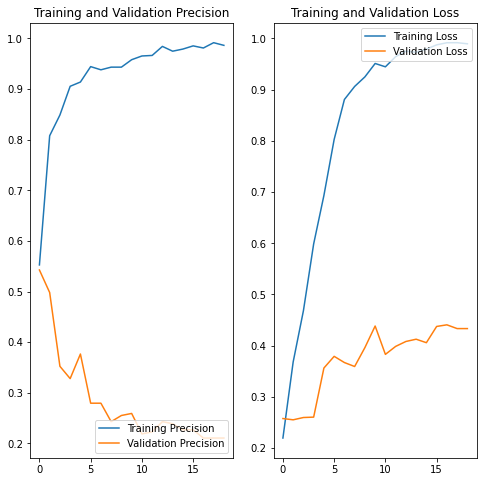

In [21]:
import matplotlib.pyplot as plt

acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['precision']
val_loss = history.history['val_precision']

epochs_range = range(19)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.evaluate(img_arr_test,y_out_test)

4/4 [==============================] - 1s 90ms/step - loss: 0.5977 - precision: 0.5316 - recall: 0.2675 - log_loss: 0.5883 - binary_accuracy: 0.8128


[0.597675085067749,
 0.5316455960273743,
 0.2675159275531769,
 0.588341474533081,
 0.8128079175949097]

In [23]:
2/(1/0.53 + 1/0.26)

0.34886075949367096

----

In [68]:
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras import Model

xx = resnet.output
xx = MaxPooling2D(pool_size=(2, 2))(xx)
xx = Flatten()(xx)

real_face_input = tf.keras.layers.Input(shape=(16,))
real_clr_input = tf.keras.layers.Input(shape=(3,))


concat = Concatenate(axis=-1)([xx, real_face_input, real_clr_input])

xx = Dropout(0.5)(concat)
xx =  Dense(512, activation='relu')(xx)
xx = BatchNormalization()(x)
xx =  Dense(256, activation='relu')(xx)
xx = BatchNormalization()(x)
xx = Dense(7, activation='sigmoid')(xx)

model = Model(inputs=[resnet.input,real_face_input,real_clr_input], outputs=xx)

In [69]:
for layer in resnet.layers:
    layer.trainable = False
    

In [74]:

optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adam',
            loss=tf.nn.weighted_cross_entropy_with_logits,
            metrics=['Precision', 'Recall', 'BinaryAccuracy'])

In [71]:
# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [72]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        [img_arr_s, fac_input_s,clr_input_s],
        y_out_s, 
        batch_size=32, 
        epochs=10, 
        validation_split=0.2
        # callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/10


TypeError: in user code:

    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\cid2r\anaconda3\envs\cookyflow\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: Missing required positional argument


In [60]:
for layer in resnet.layers:
    layer.trainable = True
    

In [61]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        [img_arr_s, fac_input_s,clr_input_s],
        y_out_s, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100
23/23 [==============================] - 3s 124ms/step - loss: 0.3421 - precision: 0.6793 - recall: 0.9790 - binary_accuracy: 0.9087 - val_loss: 0.5981 - val_precision: 0.3101 - val_recall: 0.3239 - val_binary_accuracy: 0.7262 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 126ms/step - loss: 0.3249 - precision: 0.7317 - recall: 0.9685 - binary_accuracy: 0.9270 - val_loss: 0.6054 - val_precision: 0.3165 - val_recall: 0.3036 - val_binary_accuracy: 0.7349 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 3s 126ms/step - loss: 0.3014 - precision: 0.7722 - recall: 0.9790 - binary_accuracy: 0.9415 - val_loss: 0.5696 - val_precision: 0.3578 - val_recall: 0.3360 - val_binary_accuracy: 0.7516 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 3s 126ms/step - loss: 0.2855 - precision: 0.8010 - recall: 0.9769 - binary_accuracy: 0.9498 - val_loss: 0.5845 - val_precision: 0.3318 - val_recall: 0.2996 - val_binary_accuracy: 0.7444 - lr:

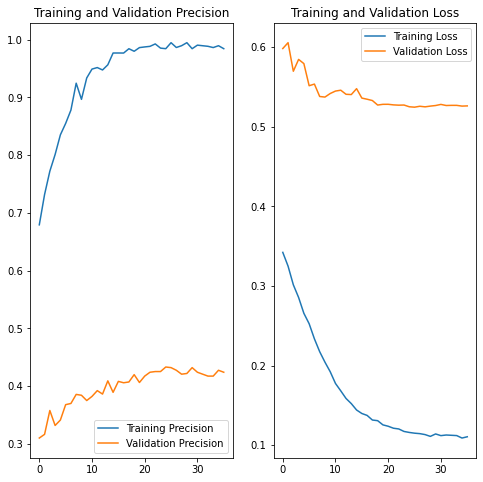

In [63]:
import matplotlib.pyplot as plt

acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(36)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
model.evaluate([img_arr_test,fac_inp_test,clr_inp_test],y_out_test)

4/4 [==============================] - 1s 92ms/step - loss: 0.5157 - precision: 0.4265 - recall: 0.1847 - binary_accuracy: 0.7943


[0.5156724452972412,
 0.4264705777168274,
 0.18471337854862213,
 0.7943350076675415]

In [67]:
2 / (1/0.427 + 1/0.185)

0.25815359477124183

In [132]:
model.save('./models/imsi.h5')

In [133]:
k = model.predict([img_arr,fac_input,clr_input])

In [134]:
k = np.array(k)

In [135]:
kk = k > 0.5

In [177]:
for i in range(len(kk)):
    print(kk[i])

[ True False False False False False False]
[False False False False False False False]
[ True False False False False False False]
[False False False False False False False]
[False False False False False False  True]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[False False False  True False False False]
[ True False False False False False False]
[False False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[False False False False False False False]
[ True False False False False False False]
[ True False False False False  True False]
[False False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False F

In [59]:
 yy = y_out > 0.5

In [60]:
from sklearn.metrics import jaccard_score

In [64]:
yy.shape

(1016, 7)

In [136]:
good = [0]

for i in range(1016):
    j = jaccard_score(kk[i],yy[i], average='micro')
    if j > 0.8:
        print(i)
        good.append(i)
    

0
2
5
6
7
8
9
11
13
14
16
19
20
21
22
23
24
25
27
28
29
31
33
34
35
36
37
38
39
40
42
43
44
47
49
50
51
52
54
55
56
57
58
59
60
61
62
63
64
65
66
67
69
70
71
72
73
74
77
78
79
80
83
85
88
89
90
91
92
93
94
95
96
97
99
100
101
102
104
105
106
107
108
109
110
111
112
113
114
115
117
118
120
121
122
123
124
125
126
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
165
166
167
168
169
170
171
172
173
174
175
176
177
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
196
198
199
200
201
202
203
205
206
207
208
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
234
236
237
238
239
240
241
242
243
245
247
248
249
251
252
253
254
255
257
259
261
262
263
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
284
285
287
288
289
290
296
297
298
299
300
301
302
304
305
306
307
308
309
310
314
315
316
319
320
321
322
323
324
326
327
328
329
330
33

In [68]:
good

[0,
 0,
 2,
 6,
 7,
 8,
 9,
 11,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 29,
 31,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 43,
 44,
 47,
 49,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 73,
 74,
 77,
 78,
 79,
 80,
 83,
 85,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 118,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 196,
 198,
 199,
 200,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 213,
 214,
 215,
 216,
 217

In [150]:
pil_img = tf.keras.preprocessing.image.array_to_img(img_arr[726])

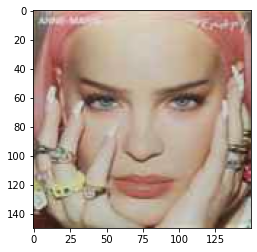

In [151]:
import matplotlib.pyplot as plt

plt.imshow(pil_img)
plt.show()

In [101]:
model.predict([[img_arr[54]],fac_input[54],clr_input[54]])

ValueError: Data cardinality is ambiguous:
  x sizes: 150, 16, 3
Make sure all arrays contain the same number of samples.

In [107]:
img_arr[54]

(191, 150, 150, 3)

In [108]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
        
#img_arr = img_arr/255.0

In [182]:
my_img_arr = np.expand_dims(img_arr[54], axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[831], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[1007], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[991], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[726], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[396], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[992], axis=0), axis=0)

np.save('./show/imgarr', my_img_arr)

In [183]:
my_fac_arr = np.expand_dims(fac_input[54], axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[831], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[1007], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[991], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[726], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[396], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[992], axis=0), axis=0)

np.save('./show/facearr', my_fac_arr)

In [184]:
my_clr_arr = np.expand_dims(clr_input[54], axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[831], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[1007], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[991], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[726], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[396], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[992], axis=0), axis=0)

np.save('./show/clrarr', my_clr_arr)

In [185]:
my_y_out = np.expand_dims(y_out[54], axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[831], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[1007], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[991], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[726], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[396], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[992], axis=0), axis=0)

np.save('./show/y', my_y_out)

In [141]:
z = model.predict([my_img_arr, my_fac_arr, my_clr_arr])

In [142]:
z = z > 0.5

In [143]:
z

array([[False,  True, False, False, False, False, False],
       [False, False,  True, False,  True, False, False],
       [False, False, False, False, False,  True, False],
       [ True, False, False, False, False,  True, False],
       [False, False,  True, False,  True, False, False]])

In [144]:
my_y_out > 0.5

array([[False,  True, False, False, False, False, False],
       [False, False,  True, False,  True, False, False],
       [False, False, False, False, False,  True,  True],
       [ True, False, False, False, False,  True, False],
       [False, False, False,  True, False, False, False]])

In [126]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets
